# Анализ бизнес-показателей

**Цель исследования:**
Выяснить, почему средства, выделенные на привлечение пользователей приложения не окупаются.

**Ход исследования:**
1. Загрузить данные и подготовить их к анализу.
2. Задать функции для расчета и анализа LTV, ROI, удержания и конверсии.
3. Провести исследовательский анализ данных, выделить профили пользователей и выяснить:

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.

4. Провести маркетинговое исследование и выяснить:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

5. Оценить окупаемость рекламы для привлечения пользователей с помощью LTV и ROI:
- Проанализировать общую окупаемость рекламы;
- Проанализировать окупаемость рекламы с разбивкой по устройствам;
- Проанализировать окупаемость рекламы с разбивкой по странам;
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам.

6. Выводы:
- Выделить причины неэффективности привлечения пользователей;
- Сформировать рекомендации для отдела маркетинга для повышения эффективности.

**Описание данных:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits, orders, costs = (                                       #загрузим данные о визитах, заказах и расходах в переменные
    pd.read_csv('/datasets/visits_info_short.csv'),  
    pd.read_csv('/datasets/orders_info_short.csv'),  
    pd.read_csv('/datasets/costs_info_short.csv')
)

In [3]:
def rename_columns(names):                                      # с помощью функции переименуем столбцы, не отвечающие 
    for i in names:                                             # требованиям по оформлению
        i.columns = i.columns.str.lower()
        i.columns = i.columns.str.replace(' ','_')
    return i
names = [visits, orders, costs]
rename_columns(names)


display(visits.head(), orders.head(), costs.head())             # посмотрим на результат

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [4]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [5]:
display(visits.isna().sum(), orders.isna().sum(), costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

In [6]:
display(visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum())

0

0

0

Попробуем также поискать дубликаты по отдельным столбцам.

In [7]:
visits[visits.duplicated(subset=['user_id', 'session_start'], keep=False)]

Empty DataFrame
Columns: [user_id, region, device, channel, session_start, session_end]
Index: []

In [8]:
orders[orders.duplicated(subset=['user_id', 'event_dt'], keep=False)]

Empty DataFrame
Columns: [user_id, event_dt, revenue]
Index: []

In [9]:
costs[costs.duplicated(subset=['dt', 'channel'], keep=False)]

Empty DataFrame
Columns: [dt, channel, costs]
Index: []

## Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для составления профилей пользователей

In [10]:
def get_profiles(sessions, purchases, ad_costs):

    
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])                   # находим параметры первых посещений
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_visit'})                       # переименуем колонку 
        .reset_index()
    )

    profiles['dt'] = profiles['first_visit'].dt.date                            # определим дату первого посещения и его месяц
    profiles['month'] = profiles['first_visit'].astype('datetime64[M]')          
    profiles['payer'] = profiles['user_id'].isin(purchases['user_id'].unique()) # определим, кто из пользователей делал покупки

    new_users = (
        profiles.groupby(['dt', 'channel'])                                     # выберем и посчитаем количество 
        .agg({'user_id': 'nunique'})                                            # уникальных пользователей, 
        .rename(columns={'user_id': 'unique_users'})                            # объединенных одинаковым источником и датой
        .reset_index()
    )
    
    new_users['dt'] = pd.to_datetime(new_users['dt'])                            # приведем столбцы к формату datetime
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')       # объединим расходы на рекламу с количеством
                                                                                 # и число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']  # поделим рекламные расходы на
                                                                                 # число привлечённых пользователей 
    profiles = profiles.merge(                                                   # добавляем стоимость привлечения в профили
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)        # заполним пустые значения

    return profiles

### Функция для расчета удержания

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions                                  # пусть список dimensions в любом случае столбец payer
    last_acquisition_date = observation_date                             # ограничиваем выборку горизонтом анализа
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        raw_data = profiles.query('dt <= @last_acquisition_date')       # выберем только те профили, которые 
                                                                        # подходят под горизонт анализа
    raw_data = raw_data.merge(                                          # соединяем "сырые" данные с данными о визитах юзеров                                           
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    raw_data['lifetime'] = (                                             # рассчитаем "лайфтайм" для каждого пользователя  
        raw_data['session_start'] - raw_data['first_visit']
    ).dt.days
 
    def group_by_dimensions(df, dims, horizon_days):                    # функция для группировки таблицы по отдельным признакам
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    retention_grouped = group_by_dimensions(raw_data, dimensions, horizon_days)   # получаем таблицу удержания

    retention_in_time = group_by_dimensions(                                      # получаем таблицу динамики удержания
        raw_data, dimensions + ['dt'], horizon_days
    )

    return raw_data, retention_grouped, retention_in_time                       #сохраняем все таблицы, которые получили

### Функция для расчета конверсии

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    last_acquisition_date = observation_date                                 # ограничиваем выборку горизонтом анализа
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    
    raw_data = profiles.query('dt <= @last_acquisition_date')                # выберем только те профили, которые 
                                                                             # подходят под горизонт анализа
    first_purchases = (                                                      # для каждого пользователя найдем 
        purchases.sort_values(by=['user_id', 'event_dt'])                    # дату первой покупки 
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    raw_data = raw_data.merge(                                               # добавляем данные о покупках в профили
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    raw_data['lifetime'] = (                                                # рассчитаем лайфтайм для каждой покупки
        raw_data['event_dt'] - raw_data['first_visit']
    ).dt.days
    
    if len(dimensions) == 0:                                             # группируем по cohort, если список dimensions пустой
        raw_data['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):                    # функция для группировки таблицы по отдельным признакам
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    conversion_table = group_by_dimensions(raw_data, dimensions, horizon_days)          # получаем таблицу конверсии

    if 'cohort' in dimensions:                                  # для таблицы динамики конверсии убираем 'cohort' из dimensions
        dimensions = []

    
    conversion_in_time = group_by_dimensions(                            # получаем таблицу динамики конверсии
        raw_data, dimensions + ['dt'], horizon_days)

    
    return raw_data, conversion_table, conversion_in_time           # возвращаем все таблицы

### Функция для расчета LTV и ROI

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_acquisition_date = observation_date                                   # ограничиваем выборку горизонтом анализа
    if not ignore_horizon:
        last_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    
    raw_data = profiles.query('dt <= @last_acquisition_date')                  # выберем только те профили, которые
                                                                               # подходят под горизонт анализа
    raw_data = raw_data.merge(                                                 # добавляем данные о покупках в профили
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    raw_data['lifetime'] = (raw_data['event_dt'] - raw_data['first_visit']).dt.days  # рассчитаем лайфтайм для каждой покупки
    
    if len(dimensions) == 0:                                              # группируем по cohort, если список dimensions пустой
        raw_data['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):                   # функция для группировки таблицы по отдельным признакам
        
        result = df.pivot_table(                                             # строим «треугольную» таблицу выручки
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        result = result.fillna(0).cumsum(axis=1)                             # находим сумму выручки с накоплением
        
        cohort_sizes = (                                                     # вычисляем размеры когорт
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)   # объединяем эти две таблицы
        result = result.div(result['cohort_size'], axis=0)      # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result[['cohort_size'] + list(range(horizon_days))]    # исключаем все лайфтаймы, превышающие горизонт анализа
        result['cohort_size'] = cohort_sizes                            # восстанавливаем размеры когорт

        
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates() # собираем датафрейм с данными пользователей 
                                                                           # и значениями CAC, добавляя параметры из dimensions
        cac = (                                                            # считаем средний CAC по параметрам из dimensions
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)             # считаем ROI: делим LTV на CAC
        roi = roi[~roi['cohort_size'].isin([np.inf])]    # удаляем строки с бесконечным ROI
        roi['cohort_size'] = cohort_sizes                # восстанавливаем размеры когорт в таблице ROI
        roi['cac'] = cac['cac']                          # добавляем CAC в таблицу ROI
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]   # в финальной таблице оставляем размеры когорт, CAC
                                                                        # и ROI в лайфтаймы, не превышающие горизонт анализа
        return result, roi                                              # возвращаем таблицы LTV и ROI
    
    ltv_table, roi_table = group_by_dimensions(             # получаем таблицы LTV и ROI
        raw_data, dimensions, horizon_days
    )
    
    if 'cohort' in dimensions:                            # для таблиц динамики убираем 'cohort' из dimensions
        dimensions = []
    
    ltv_in_time, roi_in_time = group_by_dimensions(          # получаем таблицы динамики LTV и ROI
        raw_data, dimensions + ['dt'], horizon_days
    )

    return (
        raw_data,     # сырые данные
        ltv_table,    # таблица LTV
        ltv_in_time,  # таблица динамики LTV
        roi_table,    # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для визуализации удержания

In [14]:
def filter_data(df, window):                              # функция, которая для каждого столбца применяет скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
def plot_retention(retention, retention_history, horizon, window=14):
    
    plt.figure(figsize=(15, 6))                   # задаём размер сетки для графиков

    
    retention = retention.drop(columns=['cohort_size', 0])                 # исключаем размеры когорт и удержание первого дня
    retention_history = retention_history.drop(columns=['cohort_size'])[   # в таблице динамики оставляем только нужный лайфтайм
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:                                           # если в индексах таблицы удержания только payer,
        retention['cohort'] = 'All users'                                      # добавляем второй признак — cohort
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(1, 2, 1)                               # на первом графике строим кривые удержания платящих пользователей
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

       
    ax2 = plt.subplot(1, 2, 2)                                    # на втором графике — динамика удержания платящих
    columns = [                                                   # получаем названия столбцов для сводной таблицы
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(           # фильтруем данные и строим график
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

### Функция визуализации конверсии

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    
    plt.figure(figsize=(15, 6))                                            # задаём размер сетки для графиков
    
    conversion = conversion.drop(columns=['cohort_size'])                  # исключаем размеры когорт
    conversion_history = conversion_history.drop(columns=['cohort_size'])[ # в таблице динамики оставляем только нужный лайфтайм
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)                                             # первый график — кривые конверсии
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)                                         # второй график — динамика конверсии
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']      # столбцами сводной таблицы станут 
    ]                                                                              # все столбцы индекса, кроме даты
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функции визуализации LTV и ROI

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    
    plt.figure(figsize=(25, 15))                                            # задаём размер сетки
    
    ltv = ltv.drop(columns=['cohort_size'])                                 # из таблицы ltv исключаем размеры когорт
    
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]  # в таблице динамики ltv оставляем 
                                                                            # только нужный лайфтайм

    cac_history = roi_history[['cac']]                                      # стоимость привлечения запишем в отдельный фрейм

    roi = roi.drop(columns=['cohort_size', 'cac'])                           # из таблицы roi исключаем размеры когорт и cac
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[   # в таблице динамики roi оставляем только нужный лайфтайм
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)                                                             # первый график — кривые ltv
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)                                                # второй график — динамика ltv
    columns = [name for name in ltv_history.index.names if name not in ['dt']]            # столбцами сводной таблицы станут 
                                                                                           # все столбцы индекса, кроме даты                                                                         
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)                                                   # третий график — динамика cac
    columns = [name for name in cac_history.index.names if name not in ['dt']]              # столбцами сводной таблицы станут 
    filtered_data = cac_history.pivot_table(                                                # все столбцы индекса, кроме даты
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)                                                            # четвёртый график — кривые roi
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)                                               # пятый график — динамика roi
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]        # столбцами сводной таблицы станут 
    filtered_data = roi_history.pivot_table(                                          # все столбцы индекса, кроме даты
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

In [18]:
profiles = get_profiles(visits, orders, costs)    # построим профили пользователей
profiles.head()

user_id         first_visit     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [19]:
profiles.info()   # проверим типы данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_visit       150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


In [20]:
min_analysis_date = profiles['first_visit'].min()   # минимальная дата привлечения
max_analysis_date = profiles['first_visit'].max()   # максимальная дата привлечения
display(min_analysis_date, max_analysis_date)

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Посчитаем, из каких стран приходят пользователи, и где больше всего платящих пользователей.

In [21]:
countries = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'})
countries['percentage'] = countries['payer'] / countries['user_id'] * 100
countries.sort_values(by='percentage', ascending=False)

user_id  payer  percentage
region                                   
United States   100002   6902    6.901862
Germany          14981    616    4.111875
UK               17575    700    3.982930
France           17450    663    3.799427

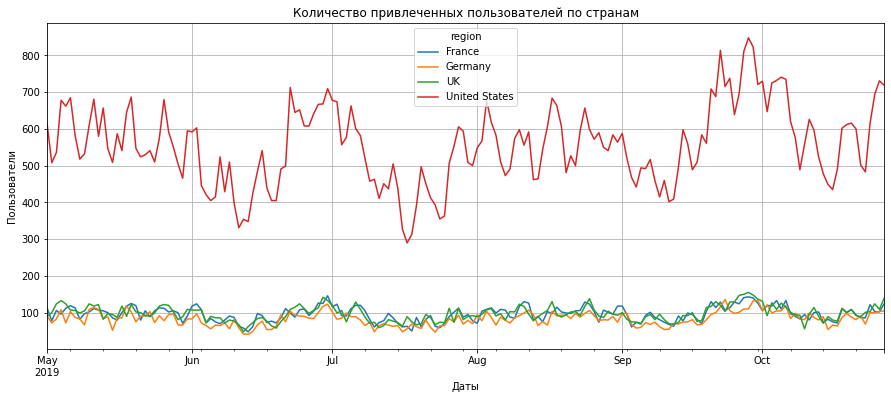

In [22]:
profiles.pivot_table(
    index='dt',        # даты первых посещений
    columns='region',  # страны
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 6), grid=True)
plt.title('Количество привлеченных пользователей по странам')
plt.xlabel('Даты')
plt.ylabel('Пользователи')
plt.show()

Больше всего уникальных пользователей пришло из США (66%), пользователи из Великобритании, Франции и Германии распределились примерно поровну (9-11%). В Соединенных Штатах больше всего платящих пользователей (почти 7%), в других странах - около 4%.

Теперь взглянем на устройства, которые они используют.

In [23]:
gadgets = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})
gadgets['percentage'] = gadgets['payer'] / gadgets['user_id'] * 100
gadgets.sort_values(by='percentage', ascending=False)

user_id  payer  percentage
device                             
Mac        30042   1912    6.364423
iPhone     54479   3382    6.207897
Android    35032   2050    5.851793
PC         30455   1537    5.046790

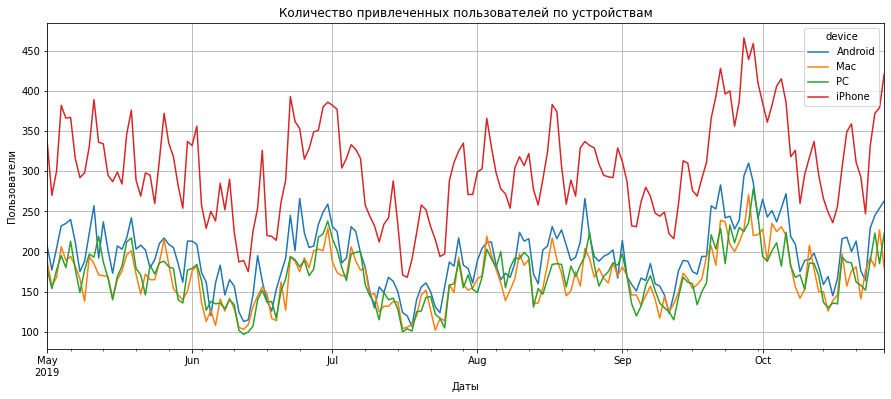

In [24]:
profiles.pivot_table(
    index='dt',        # даты первых посещений
    columns='device',  # устройства
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 6), grid=True)
plt.title('Количество привлеченных пользователей по устройствам')
plt.xlabel('Даты')
plt.ylabel('Пользователи')
plt.show()

Чаще всего пользователи приложения пользуются iPhone (36%), на втором месте по популярности - Android (23%). Персональные компьютеры и макбуки используют по 20%. Устройства компании Apple держат лидерство среди платящих пользователей (их выбирают чуть более 6%), устройства на базе Android близки к этому показателю: 5,8%. Компьютер выбирают лишь 5% платящих пользователей.

Посчитаем, через какой канал приходят большинство платящих пользователей.

In [25]:
channels = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})
channels['percentage'] = channels['payer'] / channels['user_id'] * 100
channels.sort_values(by='percentage', ascending=False)

user_id  payer  percentage
channel                                       
FaceBoom              29144   3557   12.204914
AdNonSense             3880    440   11.340206
lambdaMediaAds         2149    225   10.469986
TipTop                19561   1878    9.600736
RocketSuperAds         4448    352    7.913669
WahooNetBanner         8553    453    5.296387
YRabbit                4312    165    3.826531
MediaTornado           4364    156    3.574702
LeapBob                8553    262    3.063253
OppleCreativeMedia     8605    233    2.707728
organic               56439   1160    2.055316

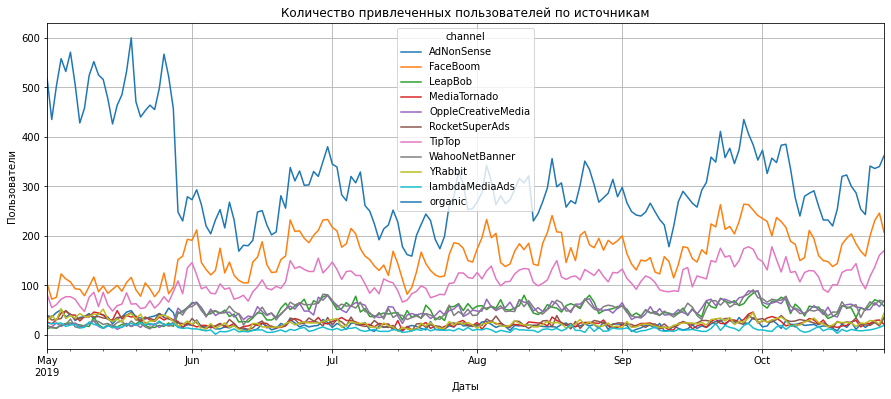

In [26]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 6), grid=True)
plt.title('Количество привлеченных пользователей по источникам')
plt.xlabel('Даты')
plt.ylabel('Пользователи')
plt.show()

Чуть больше трети пользователей пришли не по рекламным каналам, причем их пик пришелся на май 2019 года. Среди каналов с платной рекламой лидерами по числу привлеченных пользователей  являются FaceBoom (20%) и TipTop (13%). Канал FaceBoom привлекает и больше всего платящих пользователей (12%), близко к нему подбираются каналы AdNonSense (11%) и lambdaMediaAds (10%). Интересно, что по числу привлеченных пользователей они на последних местах рейтинга.

### Вывод
Самые активные пользователи приложения из США, они же чаще всего совершают покупки. Аудитория отдает предпочтение преимущественно iPhone и Mac, но устройства на платформе Android тоже достаточно популярны. Из платных каналов привлечения лучший результат показывают FaceBoom и TipTop, причем пользователи, пришедшие из FaceBoom, являются и самыми качественными. При небольшом количестве привлеченных каналы AdNonSense и lambdaMediaAds тоже показывают высокий процент качества пользователей. Возможно, эти каналы могут принести больше клиентов при увеличении расходов на рекламу.

## Шаг 4. Маркетинг

In [27]:
common_ad_costs = costs['costs'].sum()
display('Общие затраты на рекламу за неполные 6 месяцев составили ${:.1f}'.format(common_ad_costs))

'Общие затраты на рекламу за неполные 6 месяцев составили $105497.3'

In [28]:
costs.groupby('channel').sum().sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Если рассмотреть траты на рекламу по отдельным каналам, то в лидерах оказывается "TipTop": сюда ушло более половины полугодового бюджета. При этом пользователей и покупателей с этого канала пришло в 1,5 раза меньше, чем с "FaceBoom". Очевидно, что средства на "TipTop" расходуются нерационально. Чтобы увидеть, как менялись эти суммы, посмотрим разбивку рекламных трат по времени.

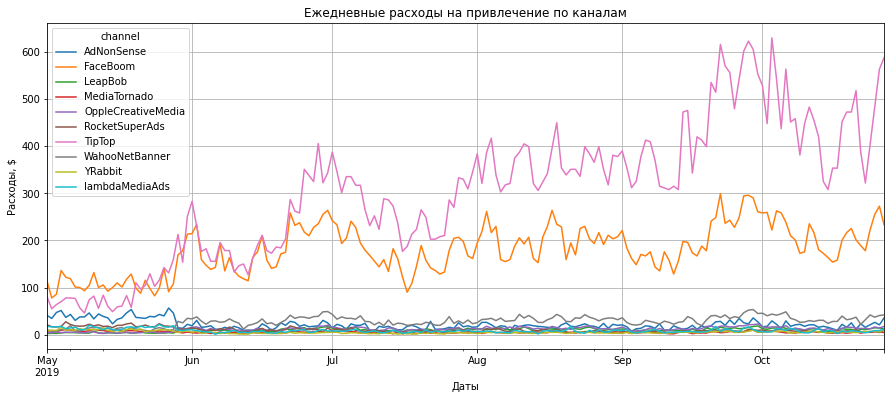

In [29]:
costs_per_channel = costs.pivot_table(
    index='dt', 
    columns='channel',  
    values='costs', 
    aggfunc='sum')
costs_per_channel.plot(figsize=(15, 6), grid=True)
plt.title('Ежедневные расходы на привлечение по каналам')
plt.xlabel('Даты')
plt.ylabel('Расходы, $')
plt.show()

На графике с самого начала выделяются лишь 3 рекламных канала: для "AdNonSense" ежедневные расходы в мае составляли около 50 долларов, но к июню значительно уменьшились. А вот у лидеров ("TipTop" и "FaceBoom") расходы к июню только растут, но как мы помним они и приводят большую часть пользователей. Траты на остальных каналах незначительные и практически не меняются за полгода. Но зато ежедневные расходы на рекламу "TipTop" к началу октября  достигают  небывалых высот: более 600 долларов. Для канала "FaceBoom" они вполовину меньше. Нужно посчитать, во что обходится приложению реклама в "TipTop" и оправданы ли такие затраты.

In [30]:
profiles.query('payer == True').groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.785961
FaceBoom              1.113243
AdNonSense            1.011119
lambdaMediaAds        0.735322
WahooNetBanner        0.600576
RocketSuperAds        0.418493
OppleCreativeMedia    0.250456
MediaTornado          0.217389
YRabbit               0.211338
LeapBob               0.210378
organic               0.000000
Name: acquisition_cost, dtype: float64

In [31]:
not_organic = profiles.query('channel != "organic"')                                   # посчитаем среднюю стоимость привлечения
not_organic.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False) # по каналам

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

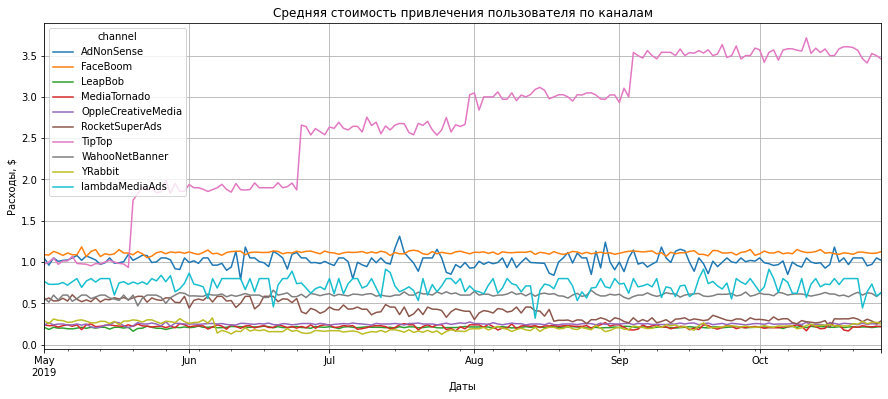

In [32]:
not_organic.pivot_table(                     # построим график без учета органических пользователей
    index='dt', 
    columns='channel',  
    values='acquisition_cost', 
    aggfunc='mean').plot(figsize=(15, 6), grid=True)
plt.title('Средняя стоимость привлечения пользователя по каналам')
plt.xlabel('Даты')
plt.ylabel('Расходы, $')
plt.show()

На графике видно, что стоимость привлечения клиента через "TipTop" постоянно росла, и в сенябре-октябре достигла 3,5 долларов, что неоправданно много. В среднем каждый покупатель, привлеченный через этот канал обошелся компании в 2,8 доллара. Это, конечно, меньше, чем сумма одной покупки, но все равно много, особенно по сравнению с другими каналами. "FaceBoom", "AdNonSense" и "lambdaMediaAds", как мы помним, привлекают по 10-12% платящих пользователей, которые обходятся в 3-4 раза дешевле.  

In [33]:
not_organic['acquisition_cost'].mean()  # рассчитаем средний CAC на одного пользователя для всего проекта

1.1274813239427588

### Вывод
Общие затраты компании на рекламу с мая по конец октября 2019 года составили более 100 тыс. долларов. Более 50% от этого бюджета было потрачено на канал "TipTop", но он лишь на 2-ом месте по количеству привлеченных пользователей (ок. 20 тыс. человек) и на 4-ом по количеству привлеченных покупателей (ок. 2 тыс. человек). Таким образом, этот канал имеет самую высокую среднюю стоимость привлечения покупателя - 3 доллара. Его конкуренты справляются намного эффективнее: например, "FaceBoom" привлек за полгода почти 30 тыс. пользователей, из которых 3,5 тыс. совершали покупки, а стоимость привлеченного покупателя составила всего 1,1 доллара. Заметен потенциал у каналов "AdNonSense" и "lambdaMediaAds", где стоимость привлечения сравнима с "FaceBoom" и даже ниже, но соотношение покупателей к пользователям одно из самых высоких в рейтинге.      

## Шаг 5. Окупаемость рекламы для привлечения пользователей

### Общая окупаемость рекламы

In [34]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14                                # горизонт анализа 

Проанализируем удержание платящих и неплатящих пользователей с помощью функции.

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic, orders, observation_date, horizon_days
)

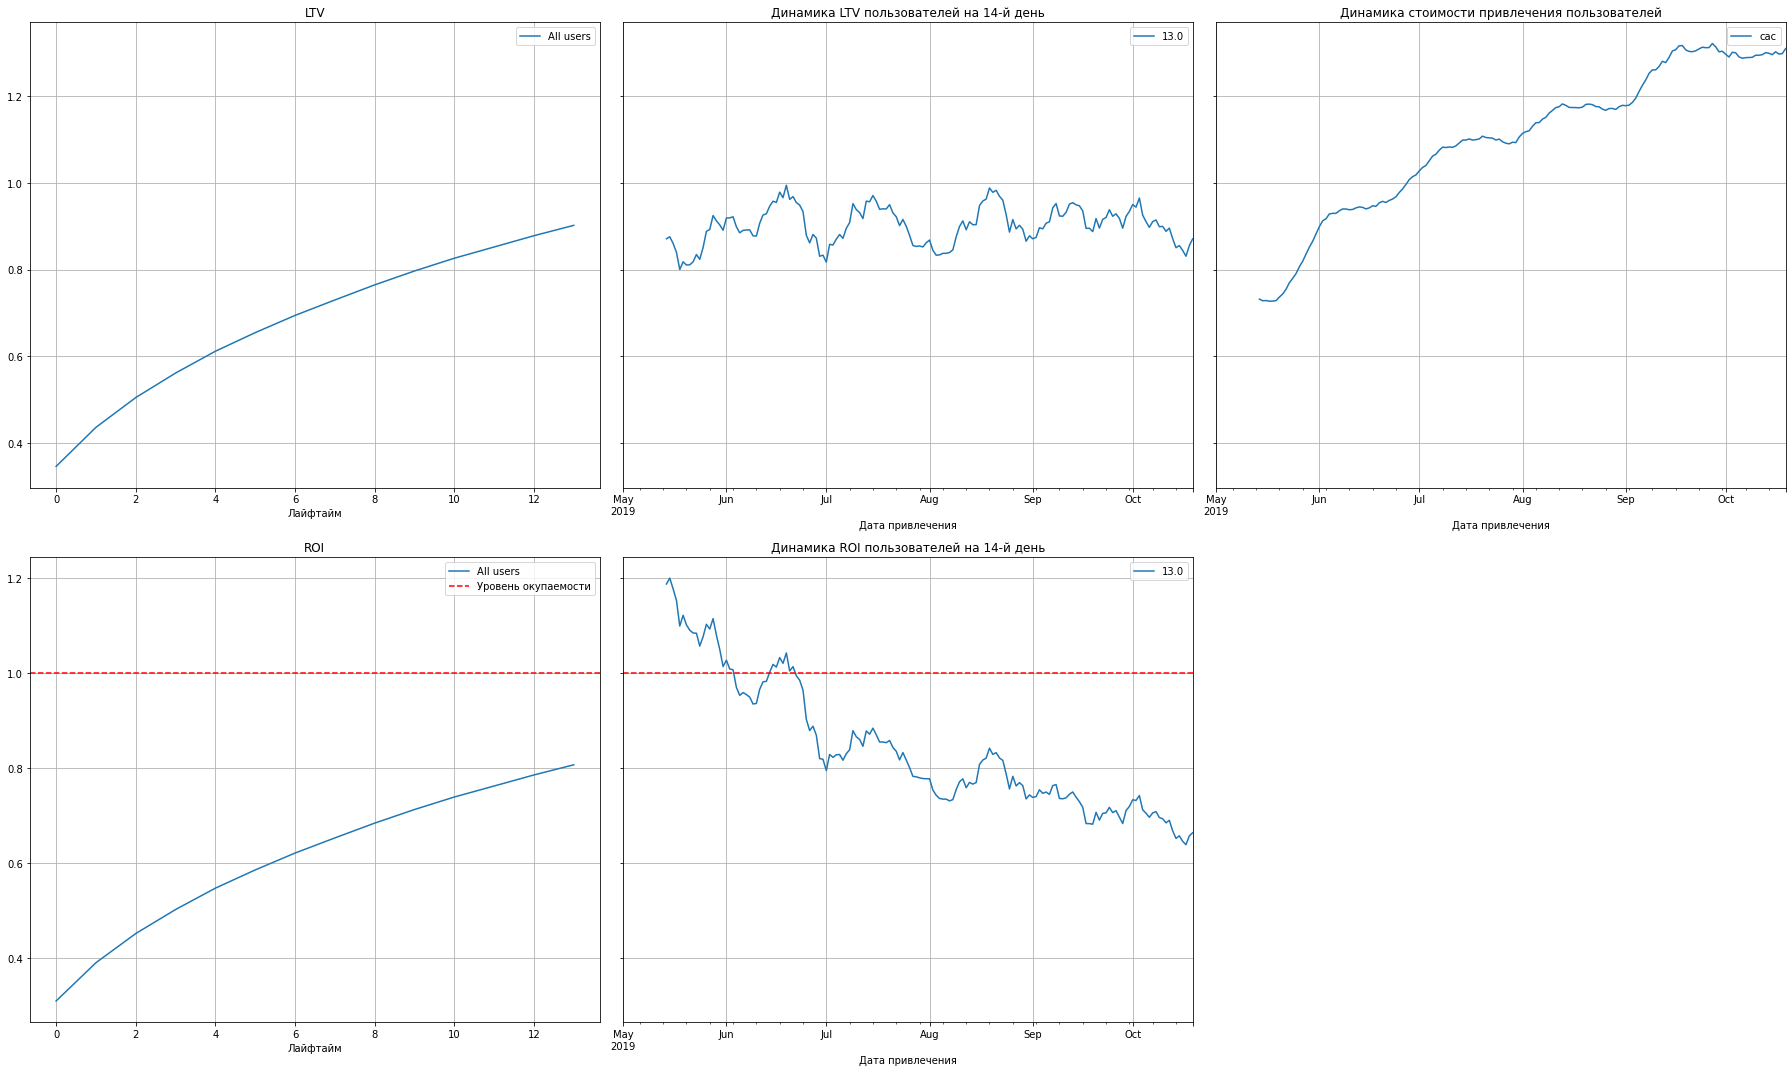

In [36]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
 - Реклама не окупается. ROI в конце периода составляет 80%.
 - CAC постояно растет, а значит бюджет на рекламу постоянно увеличивается.
 - Но при этом динамика ROI неуклонно снижается месяц за месяцем, то есть с течением времени инвестиции в рекламу окупаются все хуже.
 - Динамика LTV в целом стабильна, значит, качество пользователей сохраняется.
 
Чтобы понять, почему реклама перестала окупаться, рассмотрим все параметры пользователей - используемые устройства, страны и источники привлечения. 

### Окупаемость рекламы с разбивкой по устройствам

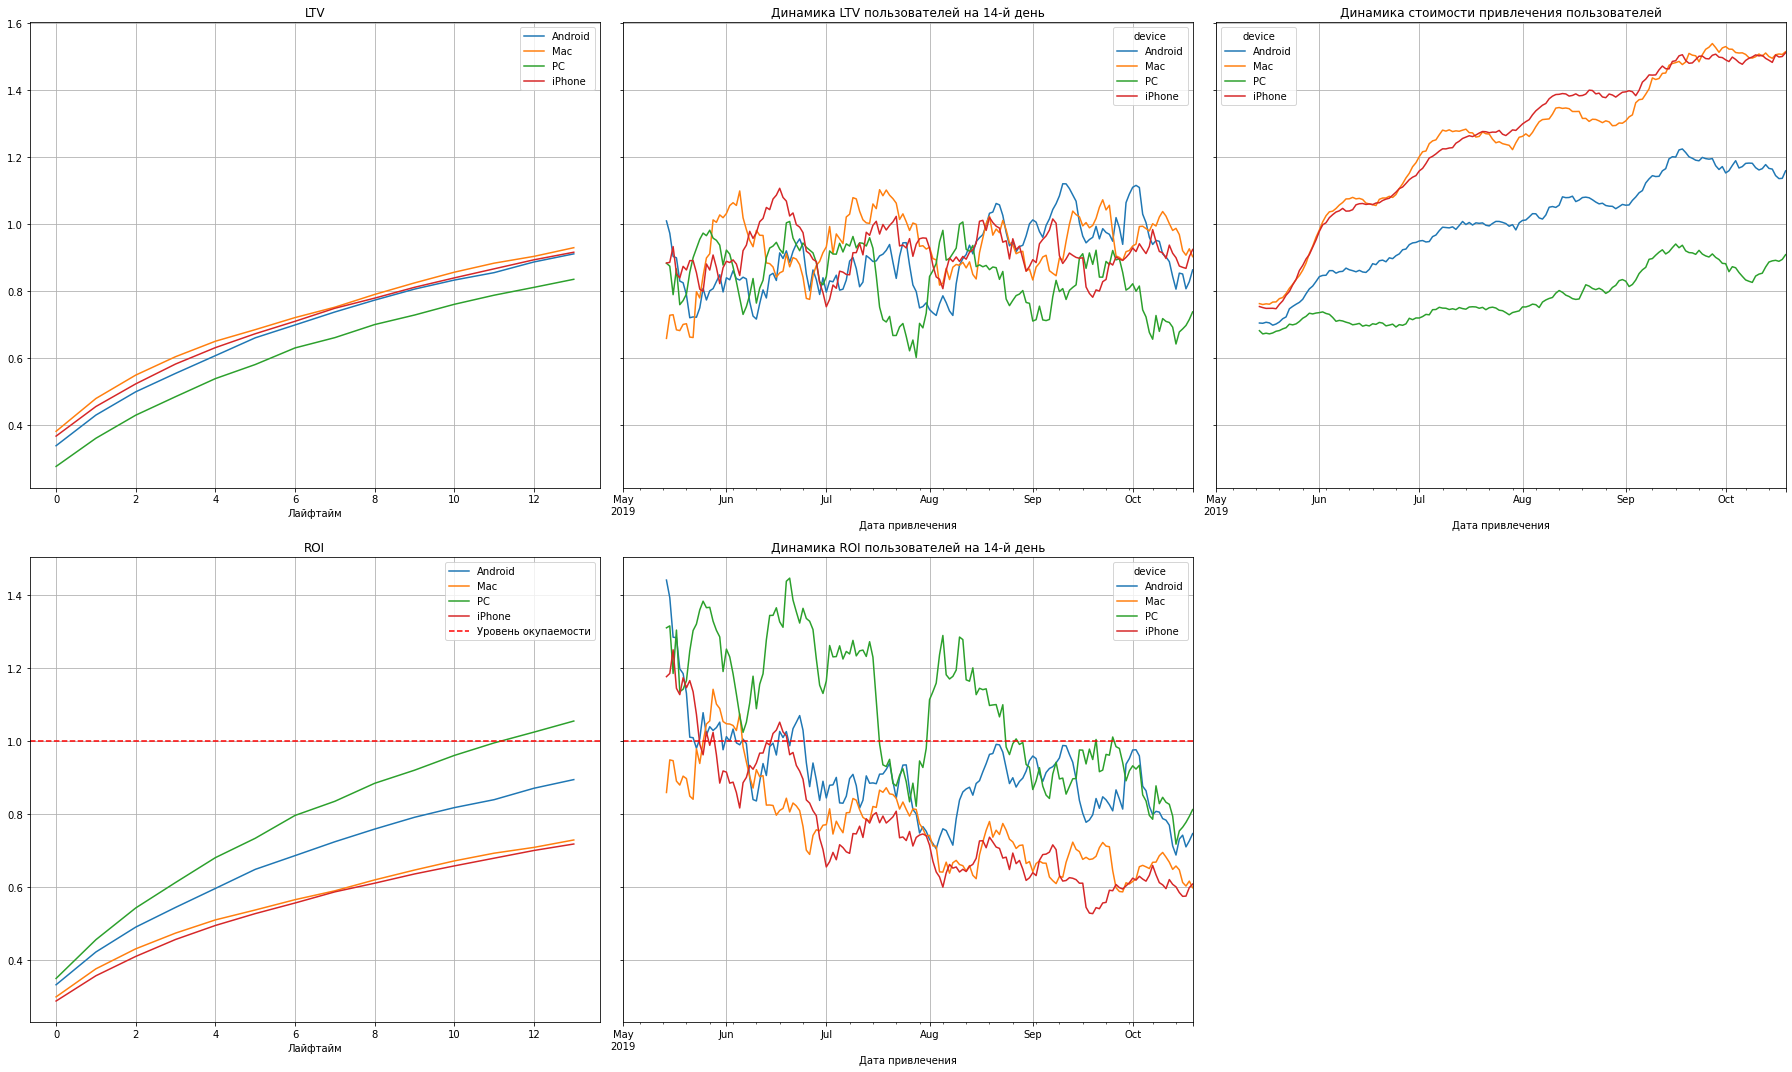

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic, orders, observation_date, horizon_days, dimensions=['device'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Выясняется, что привлечение пользователей продукции Apple (iPhone & Mac) обходится ощутимо дороже, чем других устройств. Но не окупаются ни они, ни владельцы Android. Начиная с сентября, динамика ROI для всех устройств отрицательная, а для устройств Apple, Mac, Android она падала постоянно. Узнаем, в чём причина: в низкой конверсии или низком удержании.

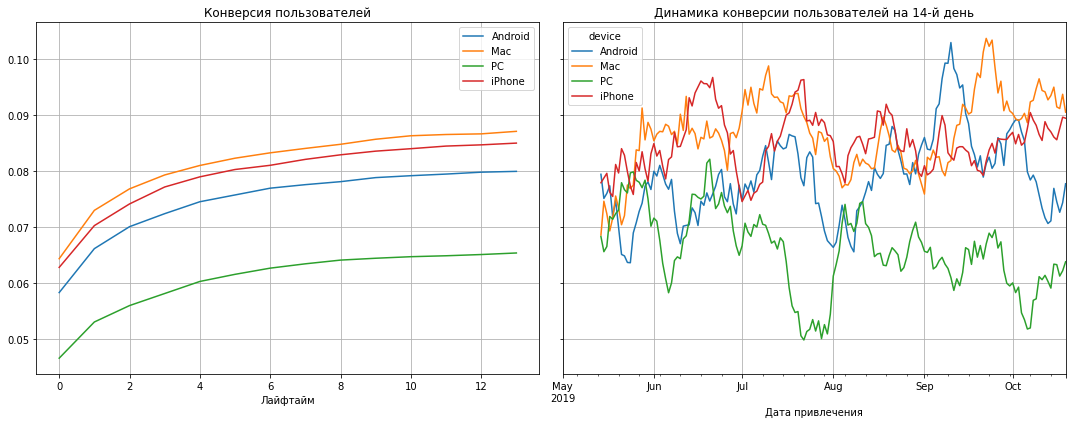

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    not_organic, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи iPhone & Mac конвертируются стабильно хорошо. В динамике пользователь всех устройств конвертируются примерно одинаково, кроме владельцев РС: всего один раз за полгода конвертация достигла пика в 8%. Проверим удержание по устройствам.

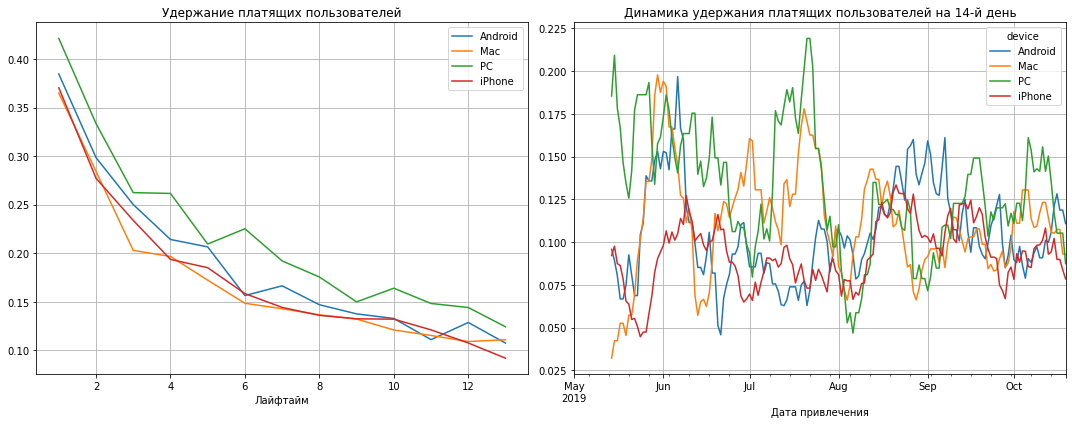

In [39]:
retention_raw, retention, retention_history = get_retention(
    not_organic, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention, retention_history, horizon_days)

По данным графикам видно, что динамика удержания платящих пользователей iPhone все время колебалась на уровне 7-12%. А вот удержание пользователей Mac падает почти в 2 раза в августе: с 17,5% до 10% и ниже. Пользователи PC первые три месяца показывали высокий уровень удержания, но к августу сравнялись с пользователями других устройств.

### Окупаемость рекламы с разбивкой по странам

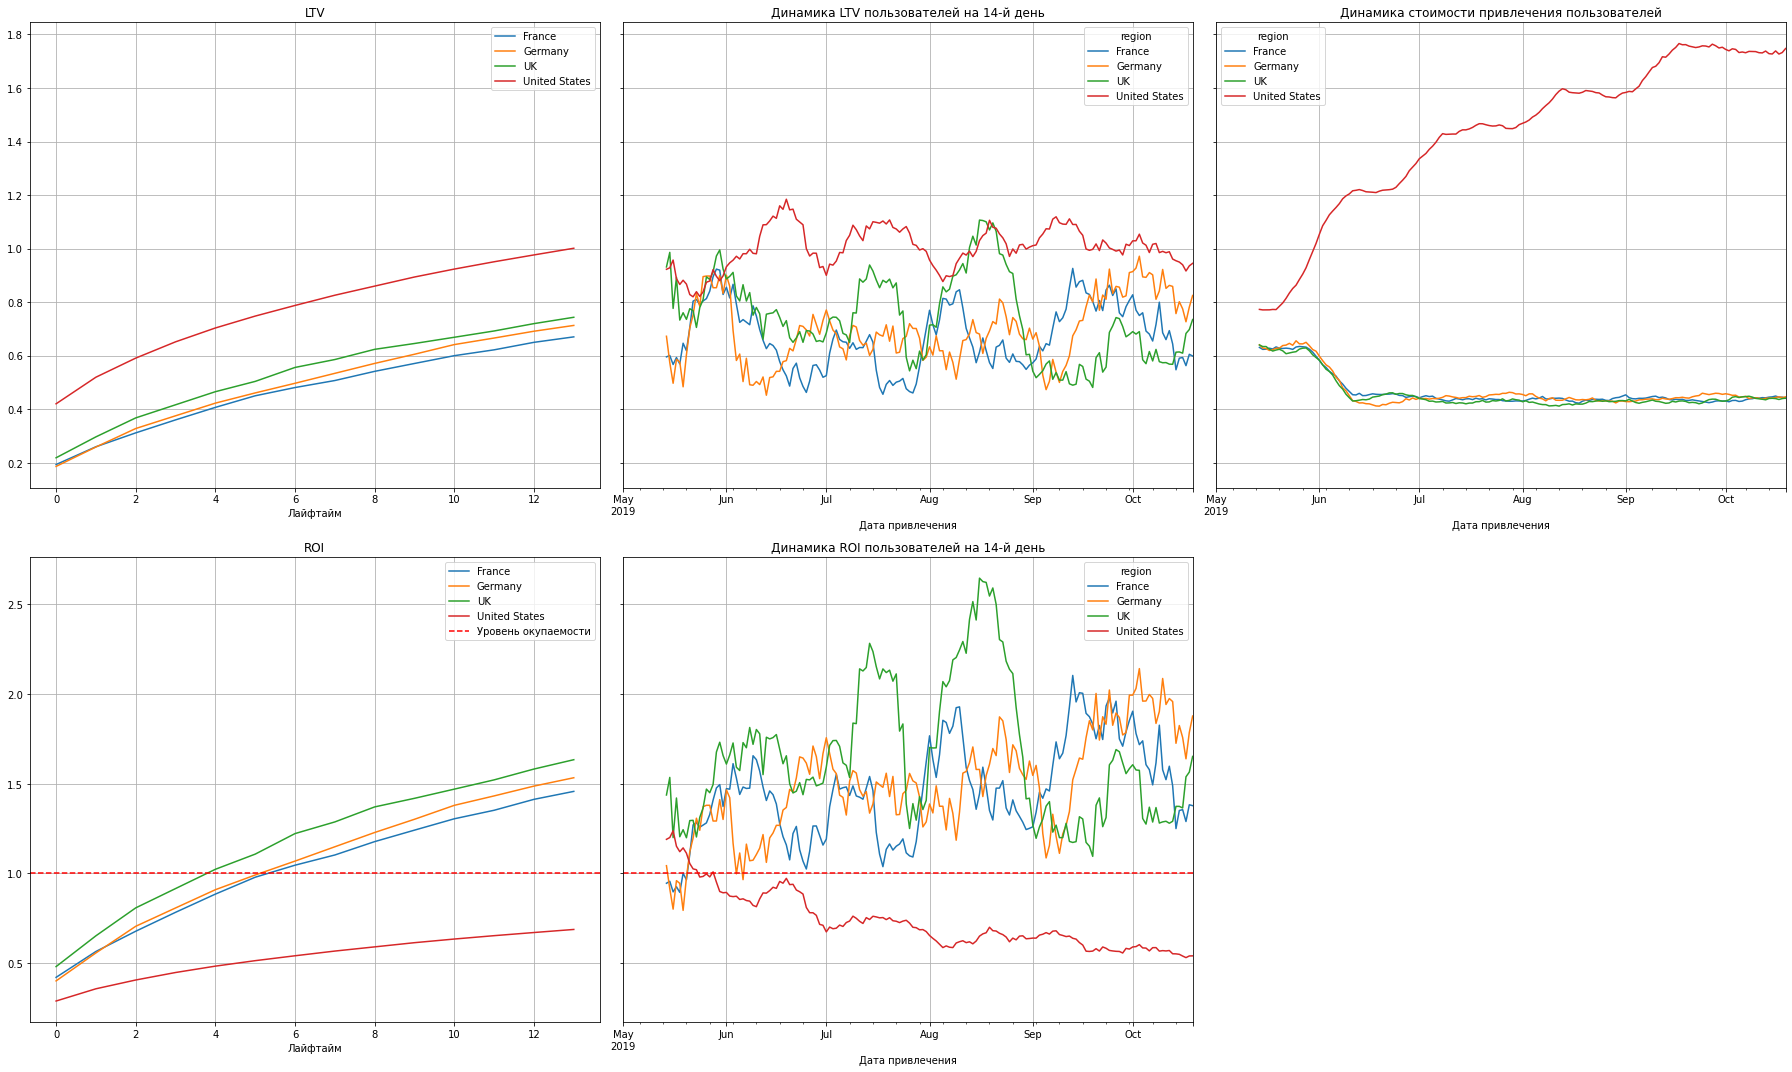

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    not_organic, orders, observation_date, horizon_days, dimensions=['region'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

В целом результат анализа окупаемости с разбивкой по странам повторяет результат предыдущего анализа. Стоимость привлечения пользователей из США растет. Но окупаемость таких крупных инвестиций всего 75%, то есть ниже необходимого. С начала лета пользователи из США стабильно не окупаются, этот момент совпадает на графике с резким ростом стоимости привлечения. При этом качество этой группы пользователей остается стабильно высоким. Посчитаем конверсию и удержание для этой категории.

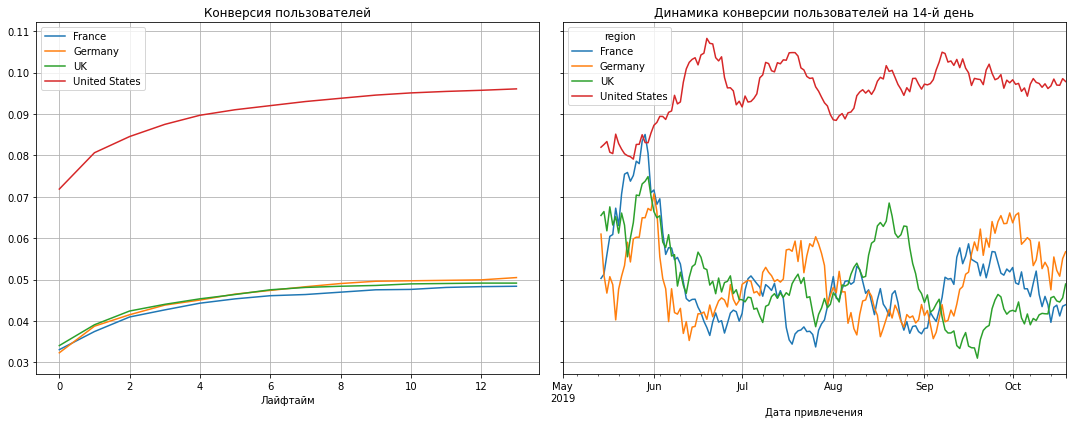

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    not_organic, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей из США стабильно высокая, в отличие от других стран. Рассмотрим удержание с разбивкой по странам.

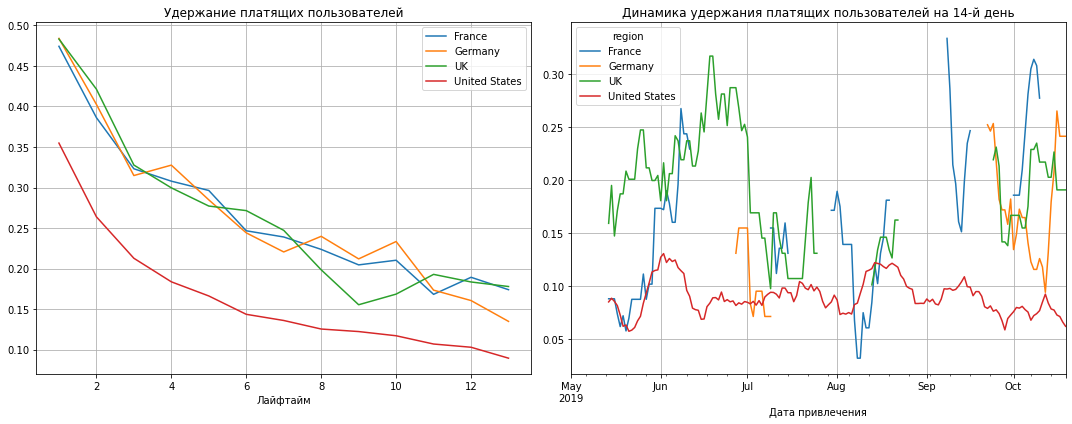

In [42]:
retention_raw, retention, retention_history = get_retention(
    not_organic, visits, observation_date, horizon_days, dimensions=['region']
)
plot_retention(retention, retention_history, horizon_days, window=14)

А вот удержание американских пользователей стабильно низкое. Возможно, приложение неудачно локализовано (т.е. приспособлено к языковым и культурным особенностям данного региона).

In [43]:
usa = not_organic.query('region == "United States"')
usa

user_id         first_visit       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
8           58263264 2019-05-11 19:18:43      FaceBoom  iPhone  United States   
9           59835779 2019-05-11 21:13:47  MediaTornado  iPhone  United States   
...              ...                 ...           ...     ...            ...   
149999  999942424543 2019-05-24 21:03:26        TipTop  iPhone  United States   
150001  999949280903 2019-08-12 06:47:27      FaceBoom     Mac  United States   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   

               dt      month  payer  acquisition_cost  
0      2019-05-07 2019-05-01   True          1.088172  
1      2019-07-09 2019-07-01  False          1.107237  
4      2019-10-02 2019-10-01  False          0.230769  
8      2019-05-11 2019-05-01  False          1.128205  
9      2019-05-11 2019-05-01  False          0.250435  
...           ...        ...    ...               ...  
149999 2019-05-24 2019-05-01  False          1.900000  
150001 2019-08-12 2019-08-01  False          1.117838  
150003 2019-09-28 2019-09-01  False          3.500000  
150005 2019-07-23 2019-07-01  False          2.600000  
150006 2019-09-28 2019-09-01  False          0.205714  

[61829 rows x 9 columns]

Рассмотрим LTV и ROI с разбивкой по устройствам отдельно для этого региона.

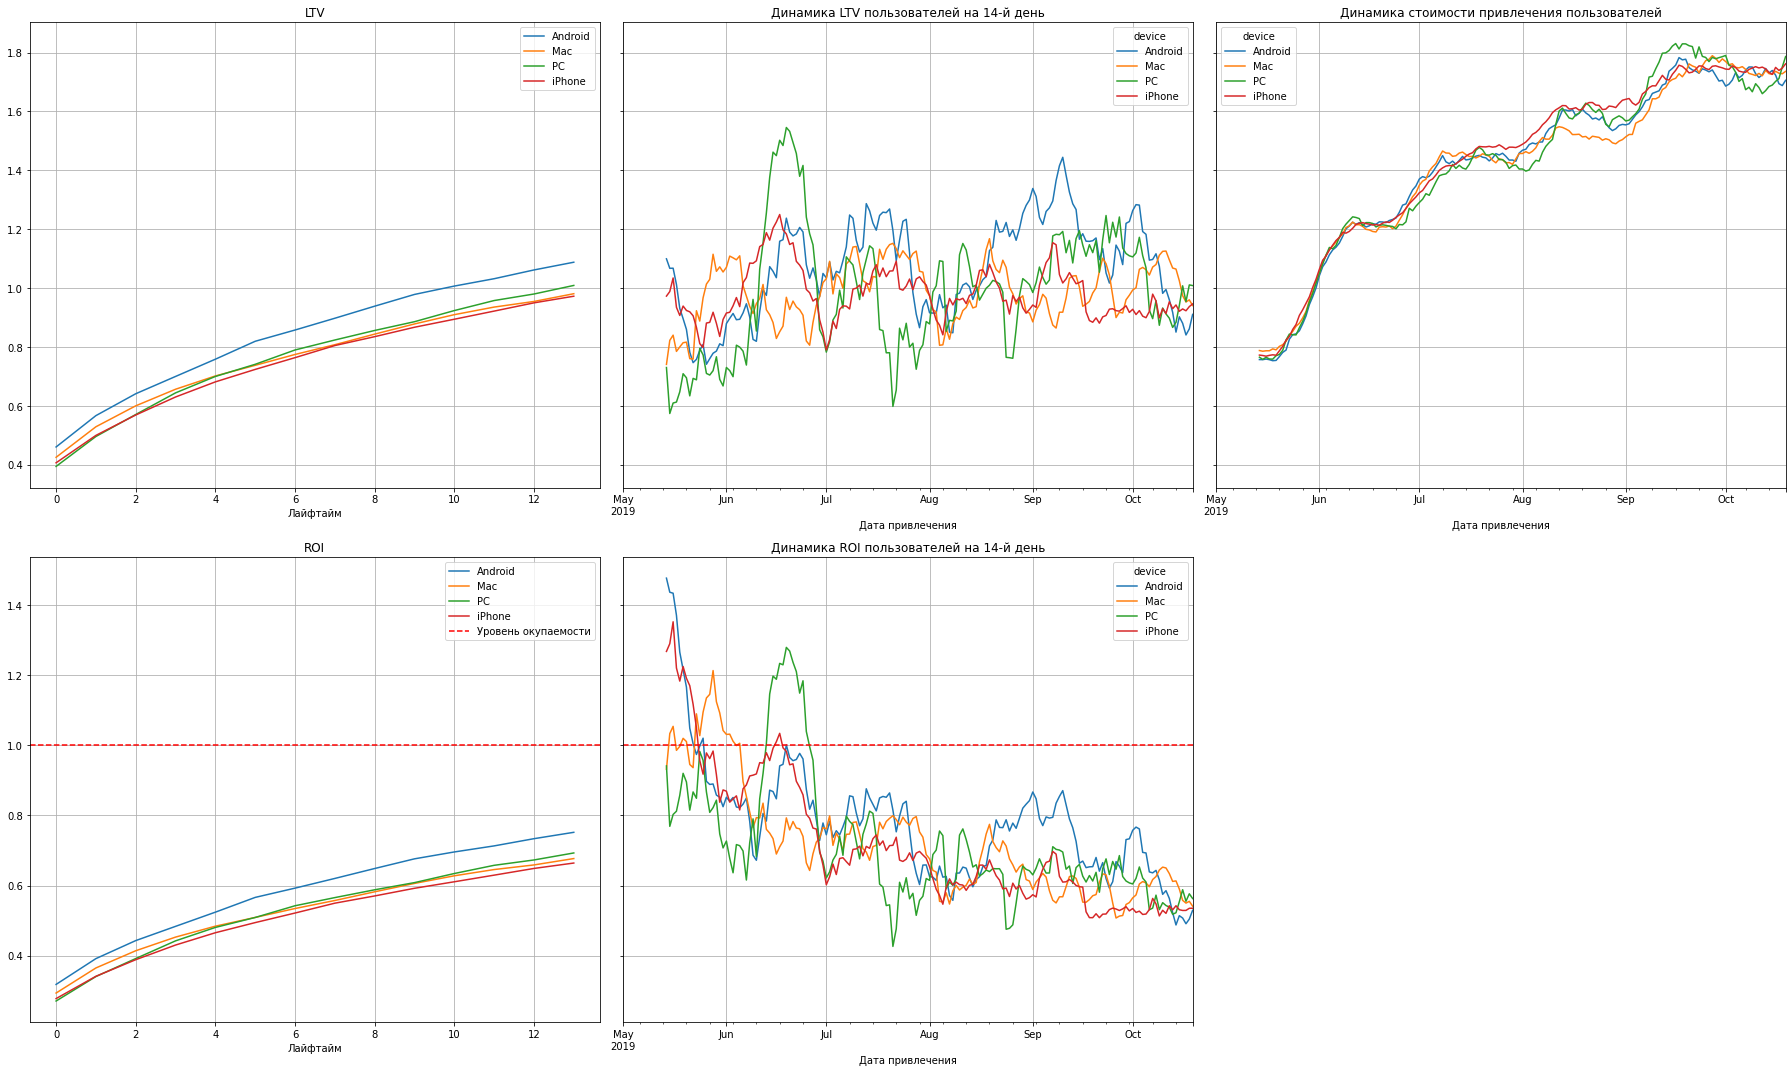

In [44]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa, orders, observation_date, horizon_days, dimensions=['device']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам видно, что статистика по всем устройствам в США одинаково печальная: несмотря на стабильное качество пользователей, стоимость их привлечения растет, но не окупается. Статистика по PC немного отличается в лучшую сторону в июне, но это не спасает положение. То есть, если в низком удержании пользователей из США виновата техническая проблема, то она присутствует на всех устройствах. Либо, причина может скрываться в самом приложении (неудачная локализация, как предполагалось выше) или неисследованных еще рекламных каналах. Анализируя окупаемость рекламы с разбивкой по каналам, учтем территориальный фактор.

### Окупаемость рекламы с разбивкой по рекламным каналам
#### В США

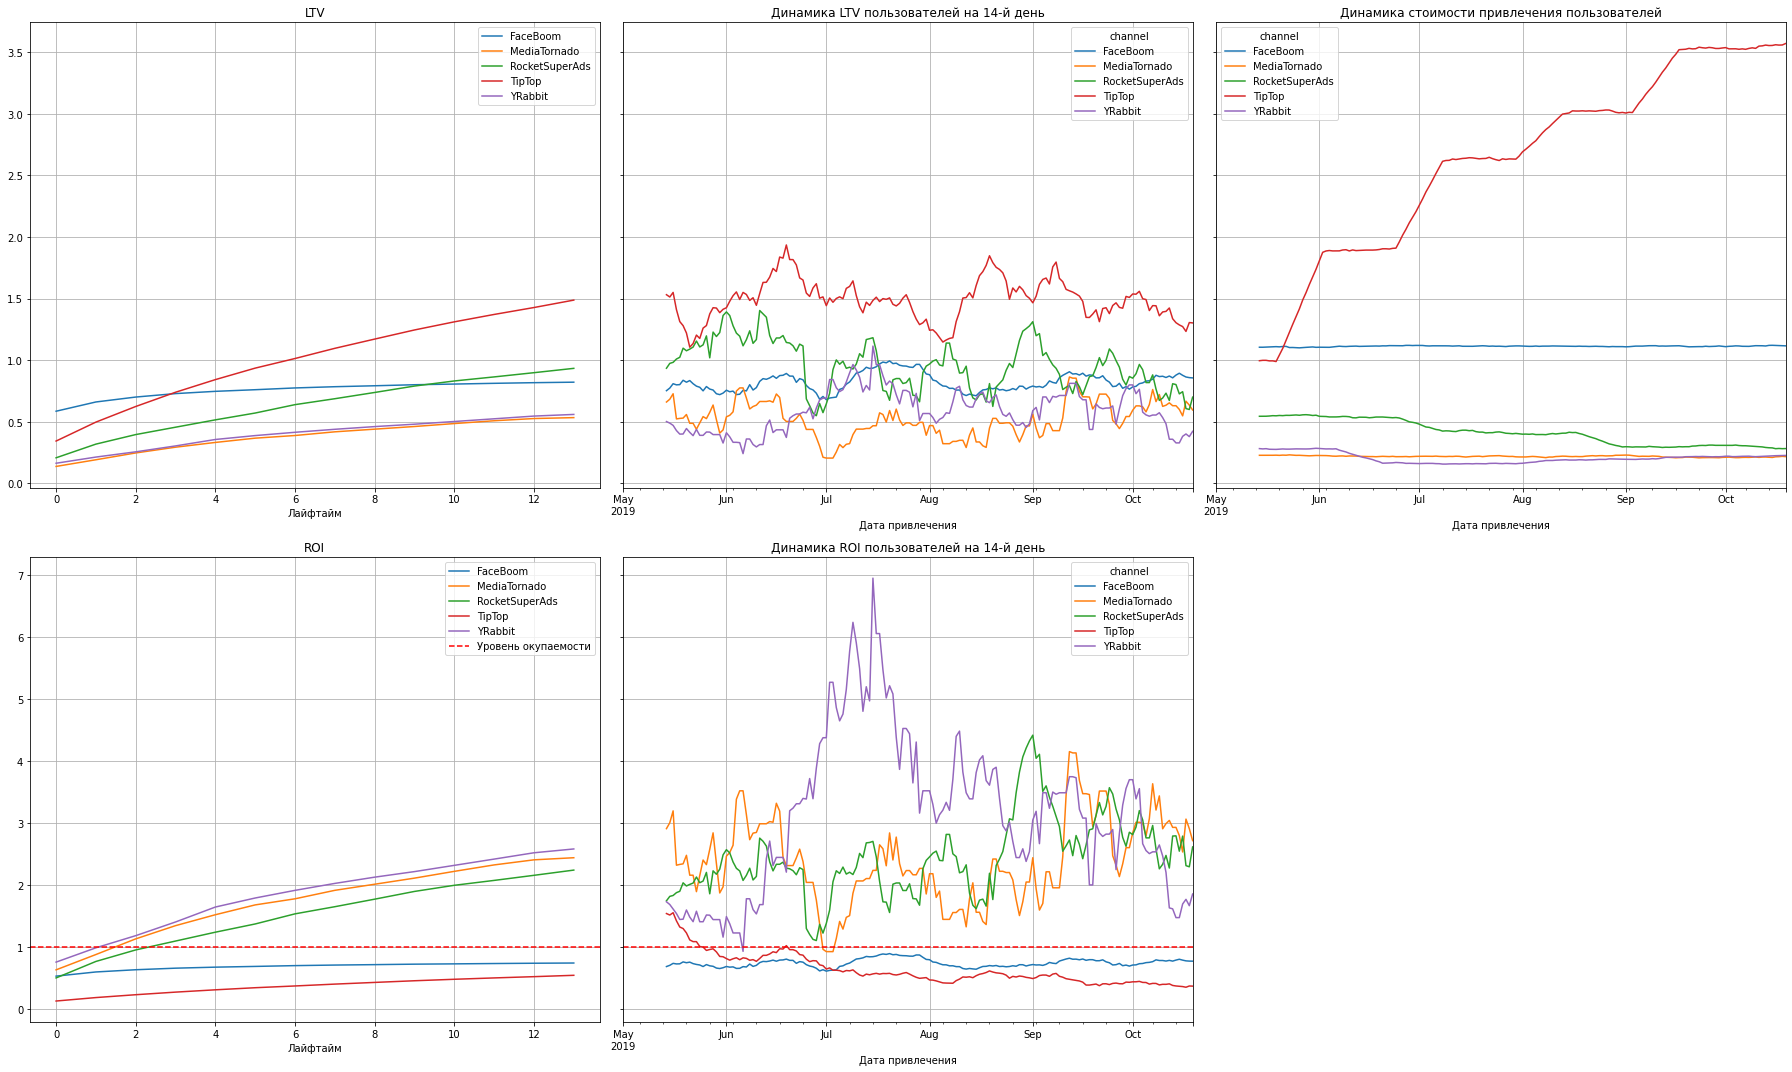

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(          # рассмотрим необходимые метрики для США
    usa, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Глядя на данные графики можно сделать следующие выводы:
- в США действует 5 рекламных каналов из 10;
- пользователи, привлеченные посредством "TipTop", отличаются стабильно высоким LTV, но постоянно растущая стоимость привлечения клиента не позволяет им окупаться;
- самые затратные каналы ("FaceBoom" и "TipTop") не окупаются, ни в течение 2 недель, ни в динамике;
- реклама на канале "YRabbit" окупается быстрее всего за счет низкой стоимости привлечения и показывает впечатляющие результаты ROI в динамике, хотя LTV пользователей при этом оставляет желать лучшего;

Посчитаем конверсию и удержание для американских каналов.

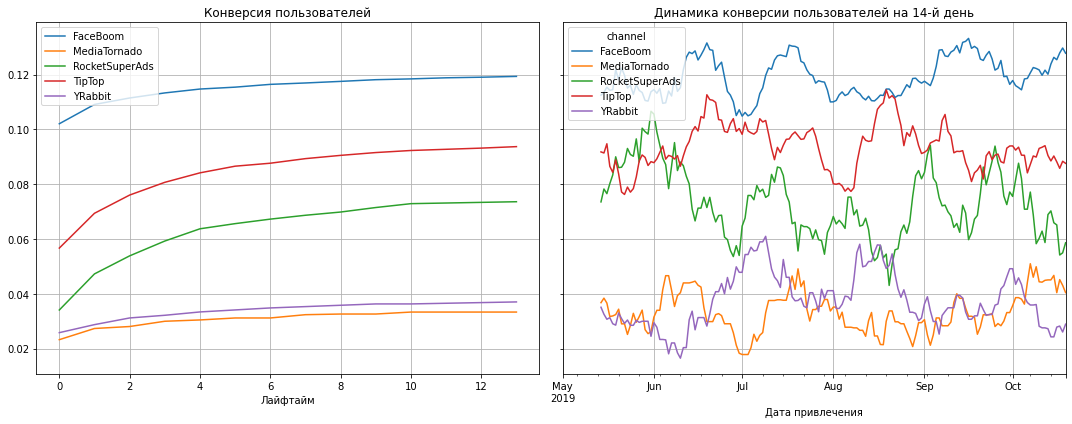

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Здесь лидеры показывают стабильно высокий результат: если судить только по этим графикам, то и не скажешь, что с этими каналами существуют проблемы. А вот конверсия для "MediaTornadо" и "YRabbit" очень низкая. Но для полноты картины стоит проанализировать удержание.

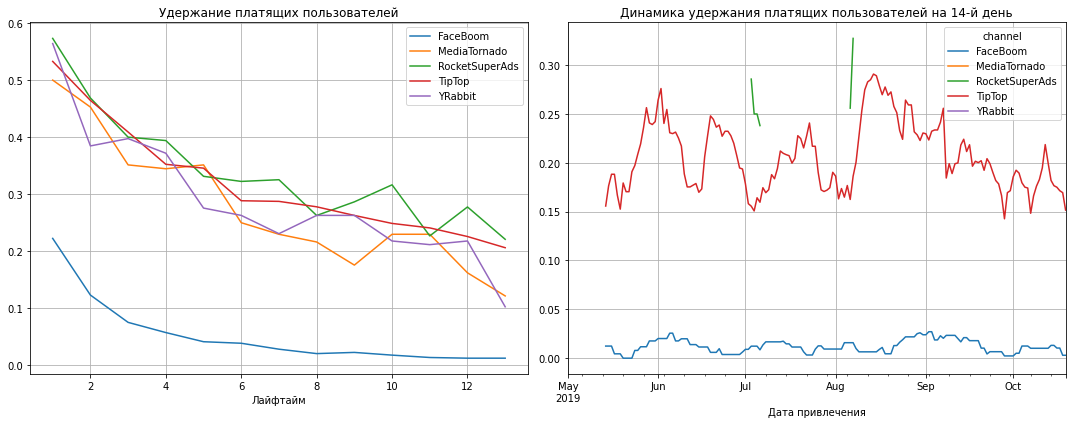

In [47]:
retention_raw, retention, retention_history = get_retention(
    usa, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention, retention_history, horizon_days)

С помощью такого графика легко понять, почему удержание пользователей из США сохраняется на таком низком уровне. Канал "FaceBoom", хотя и привлекает треть всей американской аудитории, плохо справляется с этой задачей. Может дело в том, что рекламная акция на этом канале поощряет лишь установку приложения, а не его использование, а может основная аудитория "FaceBoom" не является целевой аудиторией приложения. Канал "TipTop" удерживает пользователей значительно лучше.

#### В Европе

In [48]:
europe = not_organic.query('region != "United States"') # выделим профили пользователей из Великобритании, Германии и Франции 
                                                        # в отдельный датафрейм

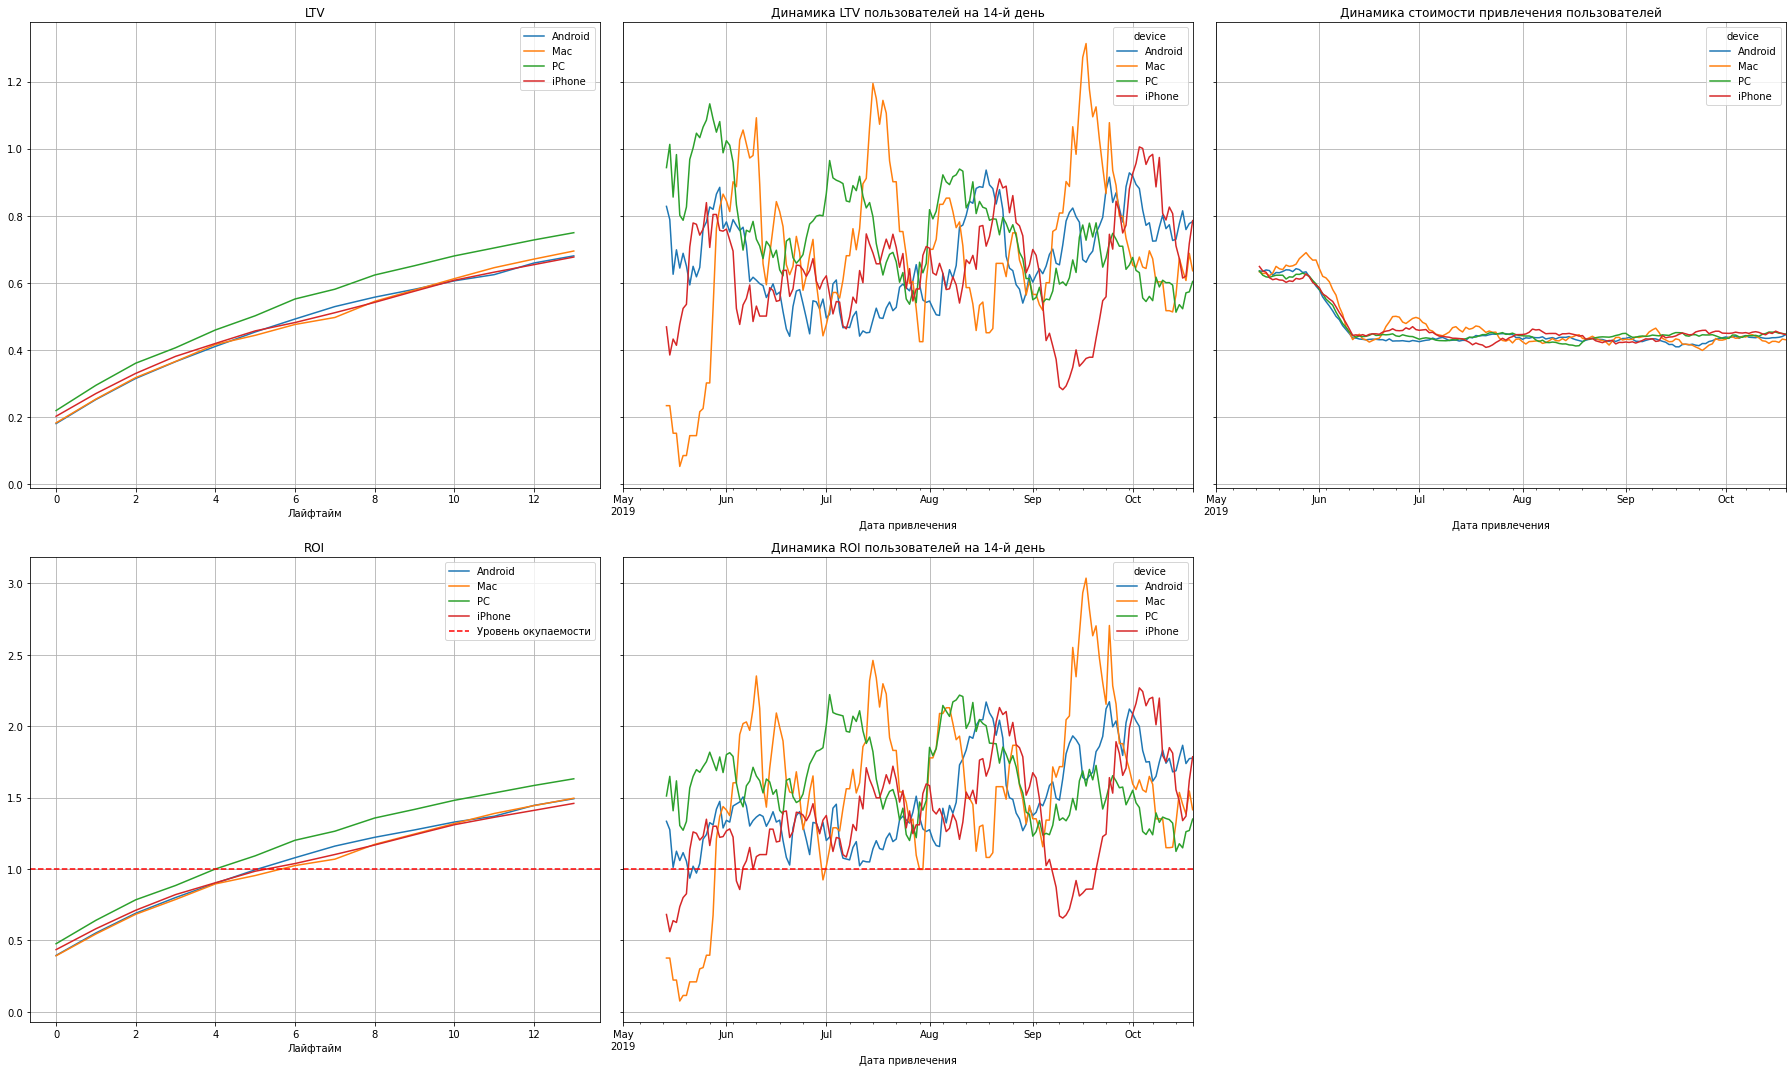

In [49]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(       # рассмотрим необходимые метрики для этих стран
    europe, orders, observation_date, horizon_days, dimensions=['device']    # с разбивкой по устройствам
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видно, что в отличие от США в Европе нет проблем с окупаемостью у владельцев разных устройств. В частности LTV и ROI для стационарных устройств (МАС и РС) остаются стабильно высокими. Редкие спады, заметные для МАС и iPhone, скорее всего, объясняются техническими проблемами при установке обновлений, но по графикам видно, что они исправляются и окупаемость возвращается на прежний уровень.

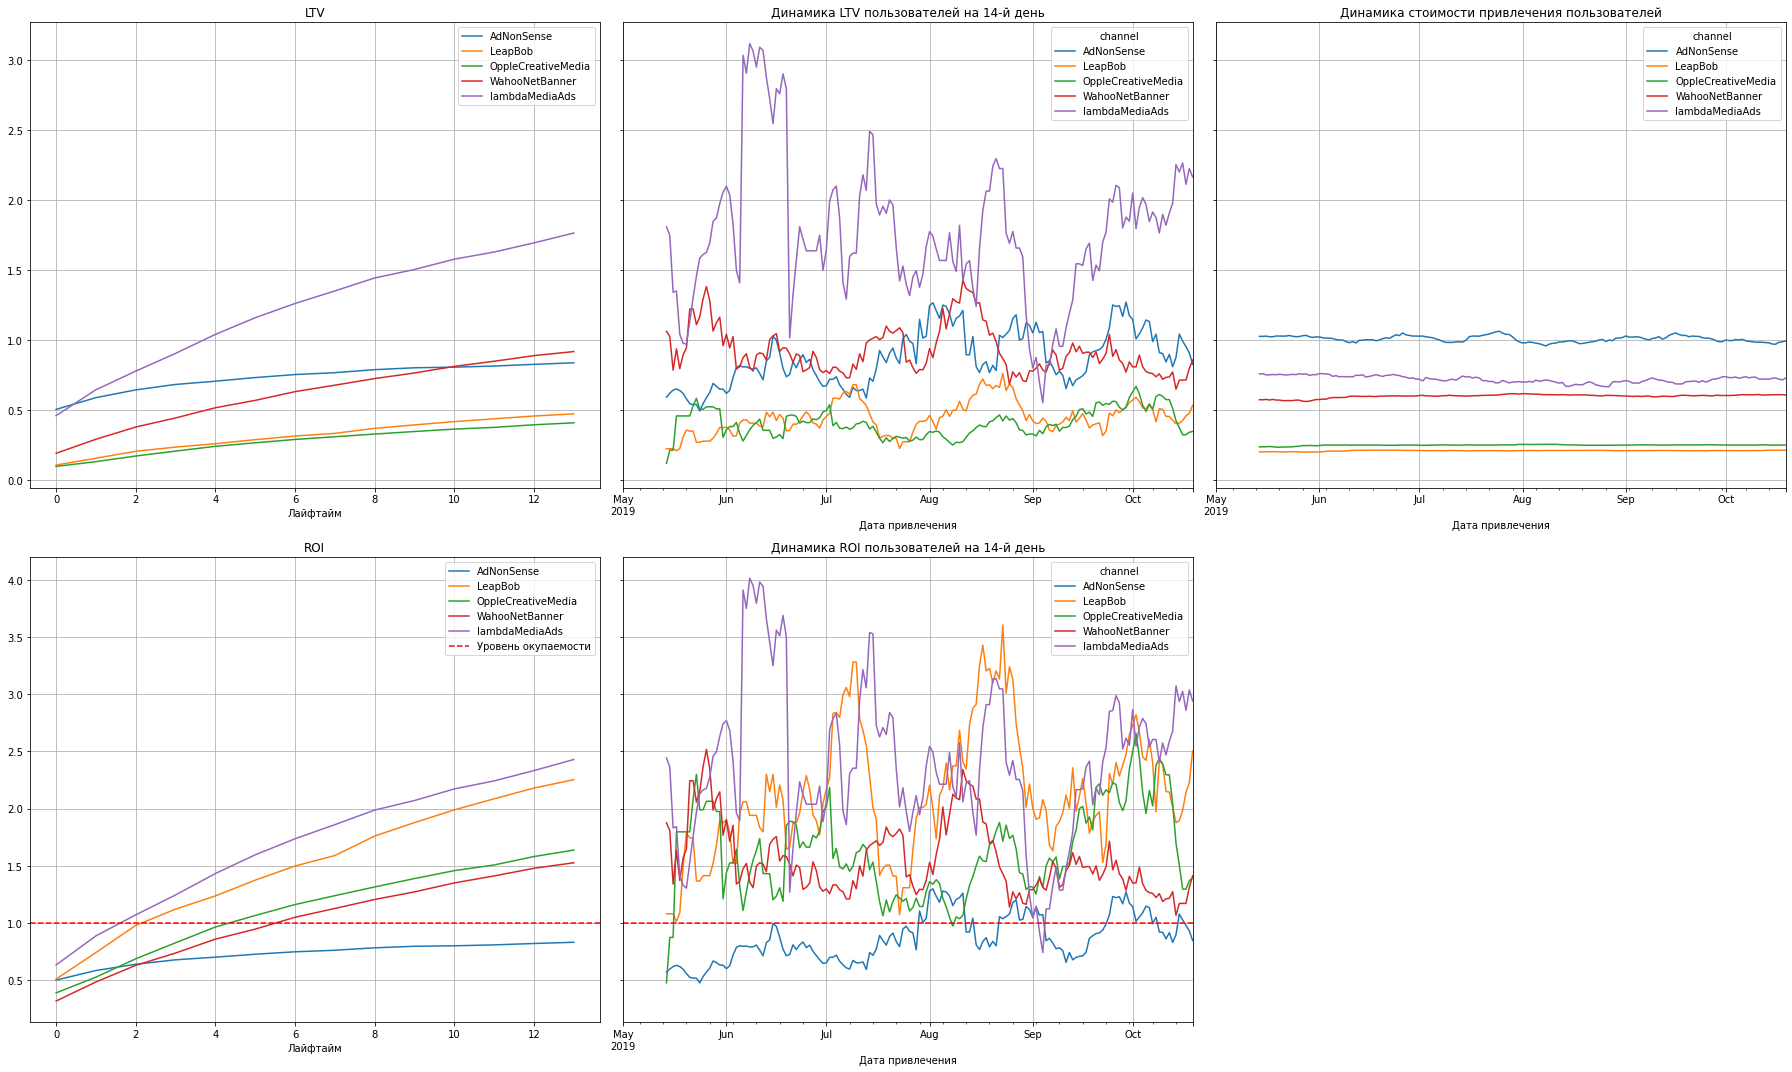

In [50]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(       # рассмотрим необходимые метрики для этих стран
    europe, orders, observation_date, horizon_days, dimensions=['channel']
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Для привлечения пользователей из Европы используются именно те 5 каналов, которые не попали на графики для США. Это удобно, так как мы можем рассматривать их независимо друг от друга.

У европейских стран тоже выделяется проблемный канал "AdNonSense": он не отличается высоким LTV, стоимость привлечения клиента здесь выше, чем у конкурентов, и, как следствие, он не окупается. Зато, явным лидером на графиках предстает канал "lambdaMediaAds", как по качеству пользователей, так и по окупаемости. Посмотрим на удержание и конверсию для рекламы в Европе.

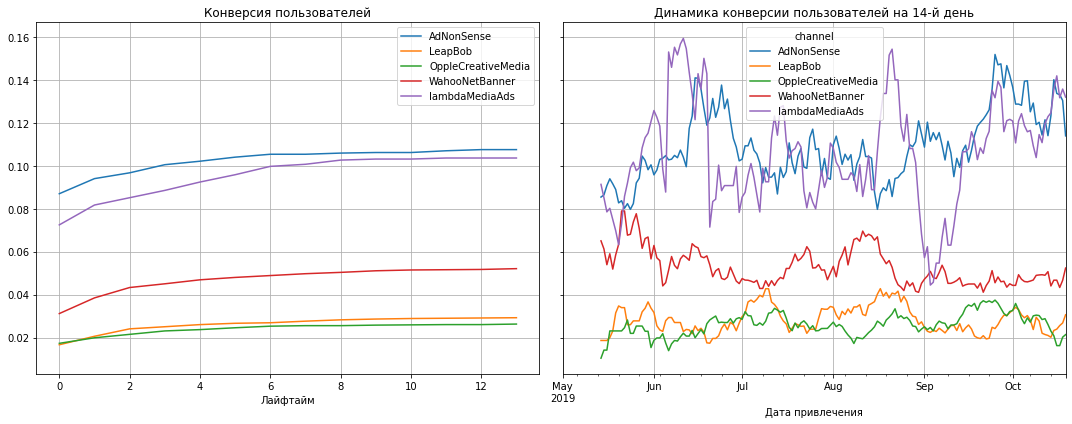

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    europe, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


Здесь "AdNonSense" и "lambdaMediaAds" показывают примерно одинаково высокие результаты, редко опускаясь ниже 8%. Конкурентам далеко до этих значений.

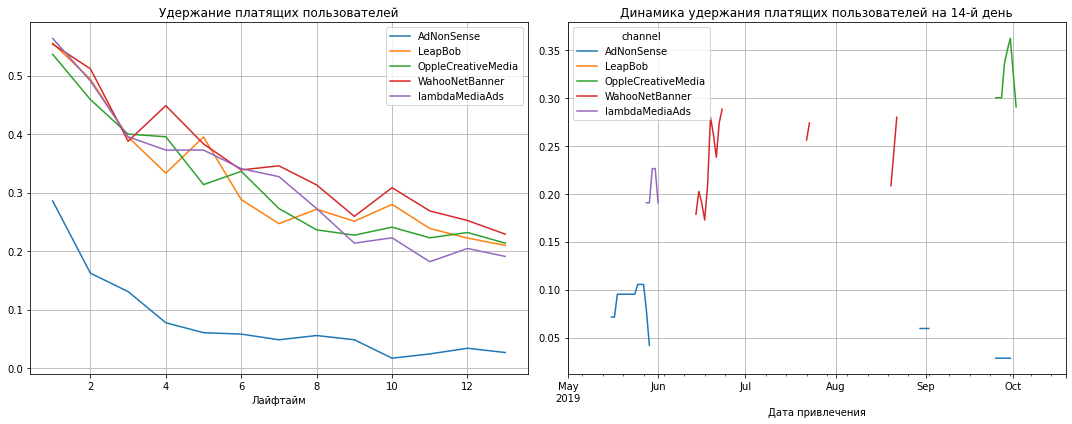

In [52]:
retention_raw, retention, retention_history = get_retention(
    europe, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention, retention_history, horizon_days)

Мы снова столкнулись с проблемой низкого удержания для канала "AdNonSense". Причины этого могут быть те же, что и в США: бонусы за установку приложения или несоответствие аудитории. В любом случае, стоит больше внимания уделить конкурентам, которые могут показать результат ничуть не хуже.

### Вывод

На настоящий момент реклама приложения не окупается, несмотря на стабильное качество пользователей и постоянно растущую стоимость привлечения клиента. Для определения причины была рассмотрена окупаемость отдельно по трем параметрам.

С точки зрения устройств окупаемость везде отрицательная. Дольше всех положительную динамику демонстрировали владельцы РС, но и они с сентября не окупаются. Скорее всего, существуют какие-то технические проблемы при использовании приложения у пользователей iPhone, Mac и Аndroid, которые в конце лета (возможно, с очередным обновлением) появились и у владельцев РС.

Проблемы наблюдаются при удержании пользователей из США, которые являются основной аудиторией приложения (66%). Этот показатель в динамике не поднимался выше 13%, тогда как для европейских стран эти значения колеблются от 10% до 30%. Скорее всего, причина этого кроется в низком удержании пользователей, привлеченных с помощью канала "FaceBoom", между тем как расходы на их привлечение составляют треть рекламного бюджета за полгода. Корни проблемы нужно искать в рекламной кампании, проводимой на этом канале, или в несовпадении целевых аудиторий. 

Еще одна проблема с рекламой в США заключается в том, что стоимость привлечения клиента на канале "TipTop" регулярно повышается, между тем как всего лишь 9,5% из этих пользователей когда-либо совершало покупки в приложении. Таким образом, инвестиции в эту рекламу не окупаются. 

Для европейских пользователей низкое удержание (не более 10%) также демонстрирует самый дорогой с точки зрения привлечения пользователей канал "AdNonSense".

### Общие выводы по проекту:
В результате проведенного исследования удалось выдвинуть несколько гипотез о причине неэффективного привлечения пользователей:

- Основные проблемы с рекламой возникают в США, на которые приходится две трети всей аудитории.
- В данном регионе низкий уровень окупаемости показывают владельцы всех типов устройств, чего не наблюдается в Великобритании, Германии и Франции, есть вероятность технических проблем или неудачной локализации приложения для американского пользователя.
- Американские пользователи, привлеченные через рекламные каналы "TipTop" и "FaceBoom", также не окупаются для компании. В первом случае причина в необоснованно завышенной стоимости привлечения клиента, которая в период с мая по октябрь увеличилась более чем в 3 раза. Во втором - в низком удержании клиентов (менее 5%), что говорит об ошибках при выборе маркетинговой стратегии (неверный выбор аудитории или стимуляция установки приложения, а не его использования).
- В Европе не окупаются затраты на рекламный канал "AdNonSense" также из-за низкого удержания. Причины, вероятно, те же: неверная рекламная стратегия.

### Рекомендации для отдела маркетинга:

1. Оценить возможность снижения стоимости привлечения клиента через канал "TipTop", потому что с точки зрения других метрик он работает эффективно.
2. Проанализировать взаимодействие с рекламными каналоми "FaceBoom" и "AdNonSense": соответствуют ли их аудитория целевой аудитории приложения, так как эти пользователи удерживаются хуже всех. Если проблема не в этом, возможно, стоит направить рекламные акции на удержание пользователей.
3. Стоит обратить внимание на альтернативные рекламные каналы, такие как "lambdaMediaAds" для европейского региона и "RocketSuperAds" для американского, которые при невысокой стоимости привлечения клиента демонстрируют хорошие показатели конверсии, удержания и окупаемости.
4. Стабильно высокое качество пользователей и быструю окупаемость демонстрируют следующие направления, которые можно считать перспективными для дальнейшего развития:
- Великобритания (в сравнении с другими европейскими странами);
- стационарные устройства европейской аудитории (РС и МАС).